In [39]:
import re
import pickle
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, precision_score, recall_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


<AxesSubplot:>

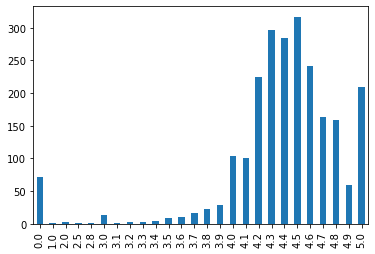

In [40]:
# Reading data and cleaning it
strain_data = pd.read_csv("cannabis.csv")
strain_data.head()

# Majority of ratings are in 4 and 5 range so can drop, won't help as feature with recommendation engine
strain_data['Rating'].value_counts().sort_index().plot.bar(figsize=(6,4))


In [41]:
# Drop the rating column
strain_data = strain_data.drop(["Rating"], axis=1)

# Drop any null value rows
strain_data = strain_data.dropna()
strain_data = strain_data[strain_data.Effects != "None"]
strain_data = strain_data[strain_data.Flavor != "None"]
strain_data = strain_data.reset_index(drop=True)
strain_data.head()


,Strain,Type,Effects,Flavor,Description
0,100-Og,hybrid,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...
1,98-White-Widow,hybrid,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...
2,1024,sativa,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...
3,13-Dawgs,hybrid,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...
4,24K-Gold,hybrid,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%..."


In [42]:
# We have 2163 strains in the dataset
strain_data.shape

effects = {"Happy"}
for effect in strain_data["Effects"].unique():
  effects.update(effect.split(",")[0].split(" "))

flavors = {"Earthy"}
for flav in strain_data["Flavor"].unique():
  flavors.update(flav.split(",")[0].split(" "))

# 16 Unique Effects and 51 Flavors
print(len(effects))
print(len(flavors))

14
47


In [43]:
# Convert data to lowercase and remove special characters
cols = ["Type", "Effects", "Flavor", "Description"]
for col_name in cols:
  strain_data[col_name] = strain_data[col_name].apply(lambda x: str(x).lower())
  strain_data[col_name] = strain_data[col_name].apply(lambda x: re.sub('[^a-zA-Z 0-9]', ' ',x))
  
# Combining all data into one feature 
strain_data["Combined"] = strain_data["Type"] + ' ' + strain_data['Effects'] + ' ' + strain_data['Flavor']

In [44]:
# Ex Combined Feature
strain_data["Combined"][0]

'hybrid creative energetic tingly euphoric relaxed earthy sweet citrus'

In [45]:
# Instantiate TFIDF vectorizer
# Using unigrams and bigrams, ignoring words that don't appear for at least 5 strains and 
# those that appear in more than 80% with max feature creation of 5000
tfidf = TfidfVectorizer(stop_words = 'english', ngram_range = (1,2), min_df = 5, max_df = 0.8, max_features = 5000)



# Storing strain df for later use
pickle.dump(strain_data, open("strain_data.pkl", 'wb'))


# Storing knn model for later use
file = open('models/tfidf_model.pkl', 'wb')

# dump information to that file
pickle.dump(tfidf, file)

# close the file
file.close()

# Transform strain texts to produce document-term-matrix(dtm)
dtm=pd.DataFrame(tfidf.fit_transform(strain_data['Combined']).todense(), columns=tfidf.get_feature_names_out())

In [46]:
# Fit on DTM, only finding 3 neighbors below
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm.values)

# Storing knn model for later use
file = open('models/kNN-5.pkl', 'wb')

# dump information to that file
pickle.dump(nn, file)

# close the file
file.close()

In [47]:
def get_recommendation(type, flavors, effects):
  # Creating user req string with all requested params
  for t in type:
      user_req = t + " "
      
  for flavor in flavors:
    user_req += flavor + " "
    
  for effect in effects: 
    user_req += effect + " "
    
  # Cleaning the user req 
  user_req = user_req.lower()
  user_req = np.asarray([user_req])
  
  distances, indices = nn.kneighbors((tfidf.transform(user_req)).todense())
  
  # Changing dimension of indices array from 2 to 1
  indices = indices[0]  
  
  return strain_data.iloc[indices]['Strain'].values, distances, indices

  

In [48]:
recs, distances, indices = get_recommendation(["Indica"], ["Citrus, Earthy"], ["Sleepy", "Happy"])
for each in indices:
  print(strain_data.iloc[each]["Strain"] + " ("  + strain_data.iloc[each]["Type"] + ")", ":", "F[" + strain_data.iloc[each]["Flavor"] +"]", "E[" + strain_data.iloc[each]["Effects"] +"]", '\n----')

White-Empress (indica) : F[sweet citrus earthy] E[energetic euphoric happy relaxed sleepy] 
----
Colorado-Clementines (indica) : F[citrus earthy orange] E[relaxed happy sleepy euphoric hungry] 
----
Skywalker (indica) : F[earthy sweet citrus] E[relaxed euphoric sleepy happy uplifted] 
----
Sweet-Lafayette (indica) : F[citrus earthy pine] E[relaxed happy euphoric uplifted aroused] 
----
Og-Cheese (hybrid) : F[cheese citrus earthy] E[relaxed creative happy sleepy uplifted] 
----


In [49]:
# Testing the model

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(dtm, strain_data['Strain'], test_size=0.2, random_state=42)


In [50]:
# Make predictions on the test data
predictions = []
distances = []
for index, row in X_test.iterrows():
  effects = strain_data.iloc[index]['Effects'].split(",")
  flavors = strain_data.iloc[index]['Flavor'].split(",")
  type = [strain_data.iloc[index]['Type']]
  recommendations, distance, indices = get_recommendation(type, flavors, effects)
  predictions.append(recommendations)
  distances.append(distance)


In [51]:
effects = strain_data.iloc[786]['Effects'].split(",")
flavors = strain_data.iloc[786]['Flavor'].split(",")
type = [strain_data.iloc[786]['Type']]

recommendations, distance, indices = get_recommendation(type, flavors, effects)
recommendations

array(['Ganesh-Berry', 'Purple-Cow', 'Purple-Headband',
       'Super-Silver-Lights', 'Atmosphere'], dtype=object)

Not completely sure about testing. Currently only testing whether KNN is at least providing the input strain as the most similar in recommendations.

In [52]:
# Evaluate the predictions
# First test is to see whether the first recommended strain in a set of recommendations is the input strain itself
for index, pred in enumerate(predictions):
  # find index of the first strain in the original data frame
  idx = strain_data.index[strain_data["Strain"] == pred[0]].to_list()
  idx = idx[0]
  idx_in_test = X_test.index[index]
  if idx != idx_in_test:
    print(idx)
    print(idx_in_test)
    print(index)
    print(pred)



1592
849
117
['Purple-Urkle' 'Grape-Ape' 'Purple-Wreck' 'Purple-Gorilla' 'Sour-Grapes']


In [53]:
idx = strain_data.index[strain_data["Strain"] == "Purple-Urkle"].to_list()[0]
idx


1592